In [1]:
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
from scipy.interpolate import interp1d
import scipy as sc
import matplotlib.cm as cm
from salishsea_tools import (nc_tools, gsw_calls, geo_tools, viz_tools)
import seabird
import cmocean as cmo
import gsw

from seabird.cnv import fCNV
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
import scipy.io
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size


from dateutil        import parser
from datetime import datetime


In [2]:
NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/NEP36_2013_T_S_Spice_larger_offshore_rho_correct.nc')


sal = NEP.variables['vosaline']
temp = NEP.variables['votemper']
spic = NEP.variables['spiciness']
rho = NEP.variables['density']

zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]

mask = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/mesh_mask.nc')

tmask = mask.variables['tmask'][0,:32,180:350, 480:650]
umask = mask.variables['umask'][0,:32,180:350, 480:650]
vmask = mask.variables['vmask'][0,:32,180:350, 480:650]
mbathy = mask.variables['mbathy'][0,180:350, 480:650]


y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


# mbathy[mbathy>32] = 32

bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')


Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon']
lat = bathy['nav_lat']

In [35]:
survey_mat_file_A = '/data/ssahu/Falkor_2013/mvp/surveyA.mat'

In [36]:
mat = scipy.io.loadmat(survey_mat_file_A)

In [79]:
depths_survey = mat['depths'][:,0]
lat_survey = mat['latitude'][:,0]
lon_survey = mat['longitude'][:,0] - 100
# den_survey = mat['density'][:]
pden_survey = mat['pden'][:]
temp_survey = mat['temp'][:]
sal_survey = mat['salinity'][:]
mtime = mat['mtime'][:,0]

In [6]:
sal_survey.shape

(251, 203)

In [41]:
survey_mat_file_B = '/data/ssahu/Falkor_2013/mvp/surveyB.mat'
mat = scipy.io.loadmat(survey_mat_file_B)

In [60]:
survey_mat_file_D = '/data/ssahu/Falkor_2013/mvp/surveyD.mat'
mat = scipy.io.loadmat(survey_mat_file_D)

In [66]:
survey_mat_file_E = '/data/ssahu/Falkor_2013/mvp/surveyE.mat'
mat = scipy.io.loadmat(survey_mat_file_E)

In [78]:
survey_mat_file_G = '/data/ssahu/Falkor_2013/mvp/surveyG.mat'
mat = scipy.io.loadmat(survey_mat_file_G)

In [13]:
sal_survey.shape

(251, 168)

In [14]:
depths_survey.shape

(251,)

In [16]:
depths_survey[-1]

250.0

In [7]:
file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

lon = file_model.variables['nav_lon'][1:,1:]
lat = file_model.variables['nav_lat'][1:,1:]

# lon = bathy['nav_lon'][180:350,480:650]
# lat = bathy['nav_lat'][180:350,480:650]

In [13]:
lon_gsw = np.mean(lon)
lat_gsw = np.mean(lat)


In [80]:
pressure_survey = np.empty_like(temp_survey)
SA_survey = np.empty_like(temp_survey)
CT_survey = np.empty_like(temp_survey)
spic_survey = np.empty_like(temp_survey)
rho_survey = np.empty_like(temp_survey)

for j in np.arange(depths_survey.shape[0]):

    for i in np.arange(lat_survey.shape[0]):

        pressure_survey[j,i] = gsw.p_from_z(-depths_survey[j],lat_survey[i])

        SA_survey[j,i] = gsw.SA_from_SP(sal_survey[j,i], pressure_survey[j,i], lon_survey[i], lat_survey[i])

        CT_survey[j,i] = gsw.CT_from_pt(sal_survey[j,i], temp_survey[j,i])

        spic_survey[j,i] = gsw.spiciness0(SA_survey[j,i], CT_survey[j,i])

        rho_survey[j,i] = gsw.density.rho(SA_survey[j,i], CT_survey[j,i], 0)


In [9]:
y = np.empty_like(lat_survey)
x = np.empty_like(y)


for i in np.arange(lat_survey.shape[0]):
    y[i], x[i] = geo_tools.find_closest_model_point(
               lon_survey[i],lat_survey[i],lon,lat,tols={
        'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})


In [53]:
temp_survey.shape

(251, 203)

In [81]:
SA_loc_cs = []
CT_loc_cs = []

for i in np.arange(sal_survey.shape[1]):
    SA_loc_cs = np.append(arr=SA_loc_cs, values= sal_survey[:,i][np.isfinite(sal_survey[:,i])])
    CT_loc_cs = np.append(arr=CT_loc_cs, values= temp_survey[:,i][~np.isnan(temp_survey[:,i])])

In [40]:
SA_loc_cs_A = SA_loc_cs
CT_loc_cs_A = CT_loc_cs



In [45]:
SA_loc_cs_B = SA_loc_cs
CT_loc_cs_B = CT_loc_cs

In [64]:
SA_loc_cs_D = SA_loc_cs
CT_loc_cs_D = CT_loc_cs

In [70]:
SA_loc_cs_E = SA_loc_cs
CT_loc_cs_E = CT_loc_cs

In [82]:
SA_loc_cs_G = SA_loc_cs
CT_loc_cs_G = CT_loc_cs

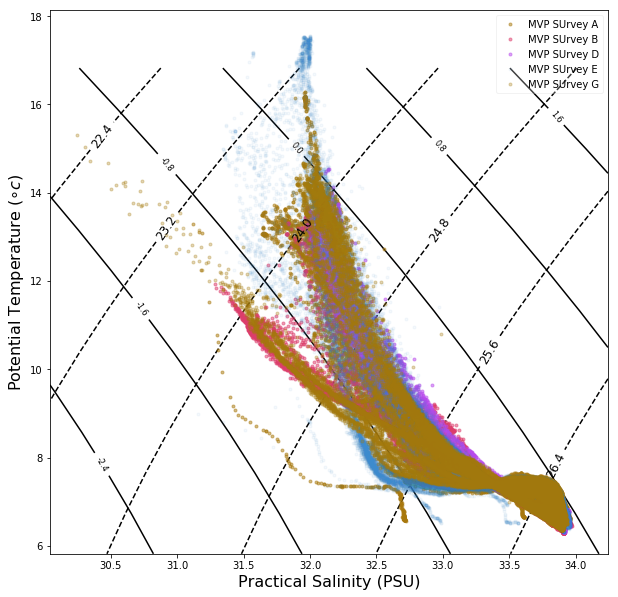

In [84]:
colors = cmo.cm.phase(np.linspace(0, 1, y.shape[0]))

SA_loc_cs_D1 = SA_loc_cs_D[SA_loc_cs_D>30]
CT_loc_cs_D1 = CT_loc_cs_D[SA_loc_cs_D>30]

# Figure out boudaries (mins and maxs)
smin = SA_loc_cs.min() - (0.01 * SA_loc_cs.min())
smax = SA_loc_cs.max() + (0.01 * SA_loc_cs.max())
tmin = CT_loc_cs.min() - (0.1 * CT_loc_cs.max())
tmax = CT_loc_cs.max() + (0.1 * CT_loc_cs.max())
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens_1 = np.empty((ydim,xdim))
spic_1 = np.empty((ydim,xdim))
SA = np.empty((xdim))
CT = np.empty((ydim)) 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        
        SA[i] = gsw.SA_from_SP(si[i], 0, lon_gsw, lat_gsw)

        CT[j] = gsw.CT_from_pt(si[i], ti[j])
        
        dens_1[j,i]=gsw.rho(SA[i],CT[j],0)
        
        spic_1[j,i] = gsw.spiciness0(SA[i],CT[j])
 
# Substract 1000 to convert to sigma-t
dens_1 = dens_1 - 1000
 
# Plot data ***********************************************
fig1, ax = plt.subplots(1, 1, figsize=(10,10))
CS = plt.contour(si,ti,dens_1, linestyles='dashed', colors='k')
CS1 = plt.contour(si,ti,spic_1, linestyles='solid', colors='k')
plt.clabel(CS, fontsize=12, inline=1, fmt='%0.1f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%0.1f') # Label every second level


ax.plot(SA_loc_cs_A ,CT_loc_cs_A,'o', color= colors[0,:], alpha = 0.5, markersize=3, label='MVP SUrvey A')

ax.plot(SA_loc_cs_B ,CT_loc_cs_B, 'o',color= colors[40,:],alpha = 0.5,  markersize=3, label='MVP SUrvey B')

ax.plot(SA_loc_cs_D1 ,CT_loc_cs_D1, 'o',color= colors[80,:],alpha = 0.5,  markersize=3, label='MVP SUrvey D')

ax.plot(SA_loc_cs_E ,CT_loc_cs_E, 'o',color= colors[120,:], alpha = 0.05, markersize=3, label='MVP SUrvey E')

ax.plot(SA_loc_cs_G ,CT_loc_cs_G, 'o',color= colors[200,:], alpha = 0.3, markersize=3, label='MVP SUrvey G')

# ax.plot(SA_loc_f, CT_loc_f, 'o' ,markersize=9, label = 'Eddy west front')
# ax.set_ylim(5,18)
# ax.set_xlim(30,34)
 
ax.set_xlabel('Practical Salinity (PSU)', fontsize = 16)
ax.set_ylabel('Potential Temperature ($\circ c$)', fontsize = 16)
# ax.set_xlim(31.5,)


legend = ax.legend(loc='upper right', fancybox=True, framealpha=0.25)

In [ ]:
colors = cmo.cm.phase(np.linspace(0, 1, y.shape[0]))

SA_loc_cs_D1 = SA_loc_cs_D[SA_loc_cs_D>30]
CT_loc_cs_D1 = CT_loc_cs_D[SA_loc_cs_D>30]

# Figure out boudaries (mins and maxs)
smin = SA_loc_cs.min() - (0.01 * SA_loc_cs.min())
smax = SA_loc_cs.max() + (0.01 * SA_loc_cs.max())
tmin = CT_loc_cs.min() - (0.1 * CT_loc_cs.max())
tmax = CT_loc_cs.max() + (0.1 * CT_loc_cs.max())
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens_1 = np.empty((ydim,xdim))
spic_1 = np.empty((ydim,xdim))
SA = np.empty((xdim))
CT = np.empty((ydim)) 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        
        SA[i] = gsw.SA_from_SP(si[i], 0, lon_gsw, lat_gsw)

        CT[j] = gsw.CT_from_pt(si[i], ti[j])
        
        dens_1[j,i]=gsw.rho(SA[i],CT[j],0)
        
        spic_1[j,i] = gsw.spiciness0(SA[i],CT[j])
 
# Substract 1000 to convert to sigma-t
dens_1 = dens_1 - 1000
 
# Plot data ***********************************************
fig1, ax = plt.subplots(1, 1, figsize=(10,10))
CS = plt.contour(si,ti,dens_1, linestyles='dashed', colors='k')
CS1 = plt.contour(si,ti,spic_1, linestyles='solid', colors='k')
plt.clabel(CS, fontsize=12, inline=1, fmt='%0.1f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%0.1f') # Label every second level


ax.plot(SA_loc_cs_A ,CT_loc_cs_A,'o', color= colors[0,:], alpha = 0.5, markersize=3, label='MVP SUrvey A')

ax.plot(SA_loc_cs_B ,CT_loc_cs_B, 'o',color= colors[40,:],alpha = 0.5,  markersize=3, label='MVP SUrvey B')

ax.plot(SA_loc_cs_D1 ,CT_loc_cs_D1, 'o',color= colors[80,:],alpha = 0.5,  markersize=3, label='MVP SUrvey D')

ax.plot(SA_loc_cs_E ,CT_loc_cs_E, 'o',color= colors[120,:], alpha = 0.05, markersize=3, label='MVP SUrvey E')

ax.plot(SA_loc_cs_G ,CT_loc_cs_G, 'o',color= colors[200,:], alpha = 0.3, markersize=3, label='MVP SUrvey G')

# ax.plot(SA_loc_f, CT_loc_f, 'o' ,markersize=9, label = 'Eddy west front')
# ax.set_ylim(5,18)
# ax.set_xlim(30,34)
 
ax.set_xlabel('Practical Salinity (PSU)', fontsize = 16)
ax.set_ylabel('Potential Temperature ($\circ c$)', fontsize = 16)
# ax.set_xlim(31.5,)


legend = ax.legend(loc='upper right', fancybox=True, framealpha=0.25)

In [59]:
SA_loc_cs_D.shape

(15750,)

In [10]:
model_survey_sal  = np.empty((sal.shape[1],y.shape[0],y.shape[0]))
model_survey_temp = np.empty_like(model_survey_sal)
model_survey_rho  = np.empty_like(model_survey_sal)
model_survey_spic = np.empty_like(model_survey_sal)

t = 116


for i in np.arange(y.shape[0]):
    model_survey_sal[:,i,i]   = sal[t,:,y[i],x[i]]
    model_survey_temp[:,i,i]  = temp[t,:,y[i],x[i]]
    model_survey_spic[:,i,i]  = spic[t,:,y[i],x[i]]
    model_survey_rho[:,i,i]   = rho[t,:,y[i],x[i]]

In [12]:
model_survey_spic[-1,20]

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
       -24.32069969,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.  

In [13]:
model_survey_temp[model_survey_temp == 0] = np.nan
model_survey_sal[model_survey_sal == 0] = np.nan
model_survey_spic[model_survey_temp == 0] = np.nan

(3, 15)

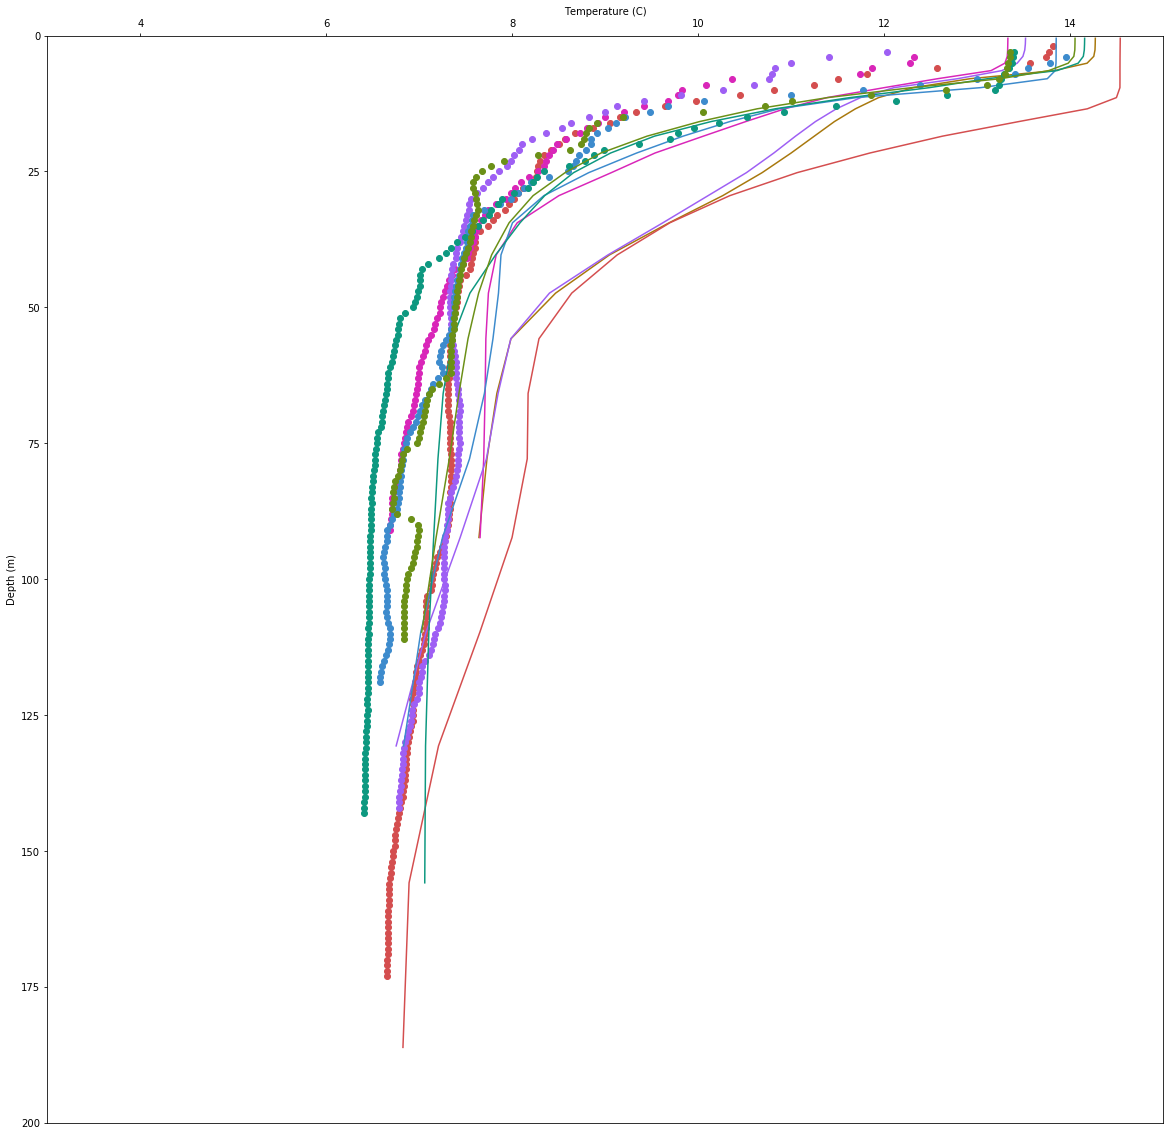

In [14]:
colors = cmo.cm.phase(np.linspace(0, 1, y.shape[0]))


# fig2, (ax2, ax3, ax4) = plt.subplots(1,3,sharey=True,figsize=(15,8))

fig2, ax2 = plt.subplots(1,1,sharey=True,figsize=(20,20))
# Temperature
for i in np.arange(0,y.shape[0],30):
    ax2.plot(model_survey_temp[:,i,i],zlevels[:], c = colors[i,:])
    ax2.plot(temp_survey[:,i] ,depths_survey[:], 'o',c = colors[i,:])
    
ax2.set_ylabel('Depth (m)')
ax2.set_ylim(0,200)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Temperature (C)')
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.set_xlim(3,15)
# # legend = ax2.legend(loc='best', fancybox=True, framealpha=0.25)
# # Salinity
# ax3.plot(sal_aug[t_aug,:26,j,i],zlevels[:26],'o',label = 'NEP36 model')
# ax3.plot(sal_data,z_data,'b',label='LA04')
# ax3.set_xlabel('Salinity')
# ax3.xaxis.set_label_position('top') 
# ax3.xaxis.set_ticks_position('top') 
# ax3.yaxis.set_visible(False) 
# ax3.set_xlim(30,35)
# legend = ax3.legend(loc='best', fancybox=True, framealpha=0.25)
# # Spiciness
# ax4.plot(spic_aug[t_aug,:26,j,i],zlevels[:26],'o',label = 'NEP36 model')
# ax4.plot(spic_data,z_data,'b',label='LA04')
# ax4.set_xlabel('Spiciness')
# ax4.xaxis.set_label_position('top') 
# ax4.xaxis.set_ticks_position('top') 
# ax4.yaxis.set_visible(False) 
# ax4.set_xlim(-1,1)
# legend = ax4.legend(loc='best', fancybox=True, framealpha=0.25)

(30, 35)

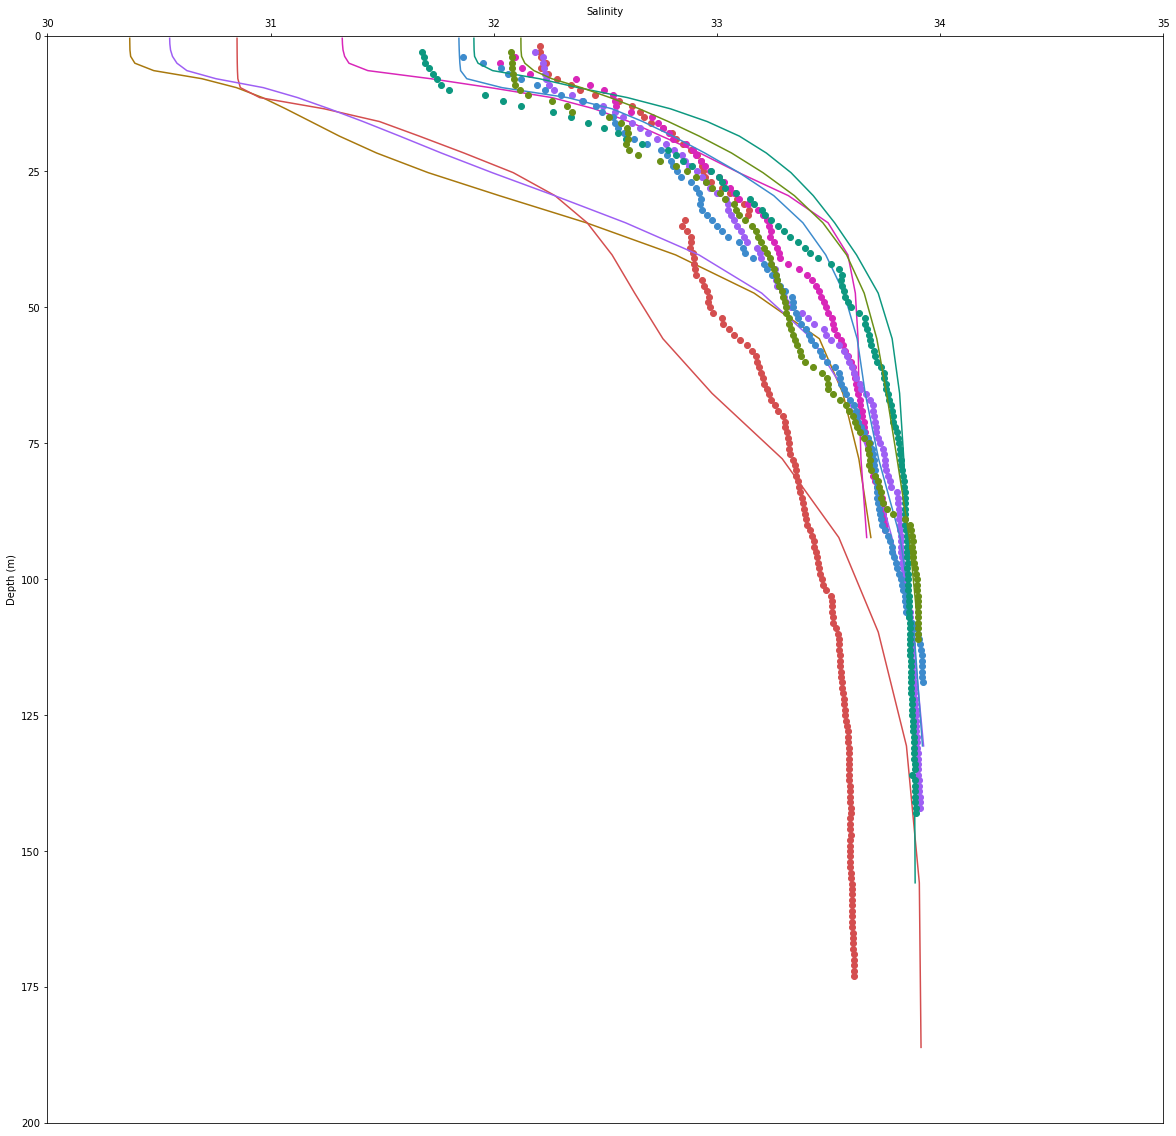

In [17]:
colors = cmo.cm.phase(np.linspace(0, 1, y.shape[0]))


# fig2, (ax2, ax3, ax4) = plt.subplots(1,3,sharey=True,figsize=(15,8))

fig2, ax2 = plt.subplots(1,1,sharey=True,figsize=(20,20))
# Temperature
for i in np.arange(0,y.shape[0],30):
    ax2.plot(model_survey_sal[:,i,i],zlevels[:], c = colors[i,:])
    ax2.plot(sal_survey[:,i] ,depths_survey[:], 'o',c = colors[i,:])
    
ax2.set_ylabel('Depth (m)')
ax2.set_ylim(0,200)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Salinity')
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.set_xlim(30,35)

In [ ]:
def add_model_MVP_data(survey_file, iso_level, survey_iso_spic, model_spic):
    
    mat = scipy.io.loadmat(survey_file)

    depths_survey = mat['depths'][:,0]
    lat_survey = mat['latitude'][:,0]
    lon_survey = mat['longitude'][:,0] - 100
    # den_survey = mat['density'][:]
    pden_survey = mat['pden'][:]
    temp_survey = mat['temp'][:]
    sal_survey = mat['salinity'][:]
    mtime = mat['mtime'][:,0]

    pressure_survey = np.empty_like(temp_survey)
    SA_survey = np.empty_like(temp_survey)
    CT_survey = np.empty_like(temp_survey)
    spic_survey = np.empty_like(temp_survey)
    rho_survey = np.empty_like(temp_survey)

    file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

    lon = file_model.variables['nav_lon'][1:,1:]
    lat = file_model.variables['nav_lat'][1:,1:]



    for j in np.arange(depths_survey.shape[0]):

        for i in np.arange(lat_survey.shape[0]):

            pressure_survey[j,i] = gsw.p_from_z(-depths_survey[j],lat_survey[i])

            SA_survey[j,i] = gsw.SA_from_SP(sal_survey[j,i], pressure_survey[j,i], lon_survey[i], lat_survey[i])

            CT_survey[j,i] = gsw.CT_from_pt(sal_survey[j,i], temp_survey[j,i])

            spic_survey[j,i] = gsw.spiciness0(SA_survey[j,i], CT_survey[j,i])

            rho_survey[j,i] = gsw.density.rho(SA_survey[j,i], CT_survey[j,i], 0)

            #Values indicate that pden is the true representative of the potential density calculated by rho_survey here


    y = np.empty_like(lat_survey)
    x = np.empty_like(y)


    for i in np.arange(lat_survey.shape[0]):
        y[i], x[i] = geo_tools.find_closest_model_point(
                   lon_survey[i],lat_survey[i],lon,lat,tols={
            'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})


    rho_0 = isot[iso_level]

    spic_rho = np.empty((spic_survey.shape[1]))


    for i in np.arange(spic_survey.shape[1]):

        spic_loc = spic_survey[:,i]
        rho_loc  = rho_survey[:,i]

        spic_rho[i] = np.interp(rho_0, rho_loc[:]-1000, spic_loc[:])

    spic_rho_finite = spic_rho[~np.isnan(spic_rho)]



    y = y[~np.isnan(spic_rho)]
    x = x[~np.isnan(spic_rho)]
    
    if survey_file == survey_mat_file_A:
        t =116
    if survey_file == survey_mat_file_B:
        t =116
    if survey_file == survey_mat_file_D:
        t =118
    if survey_file == survey_mat_file_E:
        t =119
    if survey_file == survey_mat_file_G:
        t =120

    model_add = np.empty_like(y)

    for i in np.arange(y.shape[0]):
        model_add[i] = iso_spic[t,iso_level,np.int(y[i]),np.int(x[i])]

    spic_rho_finite = spic_rho_finite[~np.isnan(model_add)]
    model_add = model_add[~np.isnan(model_add)]
    
    
#     model_add[np.isnan(model_add)] = 0
#     model_add = np.ma.masked_equal(model_add, value=0)



    survey_iso_spic = np.append(arr= survey_iso_spic,  values= spic_rho_finite)
    
    

    model_spic = np.append(arr= model_spic, values=model_add)
    
    return survey_iso_spic, model_spic




In [77]:
colors = matplotlib.cm.rainbow(np.linspace(0, 1, y.shape[0]))

In [79]:
colors.shape

(203, 4)

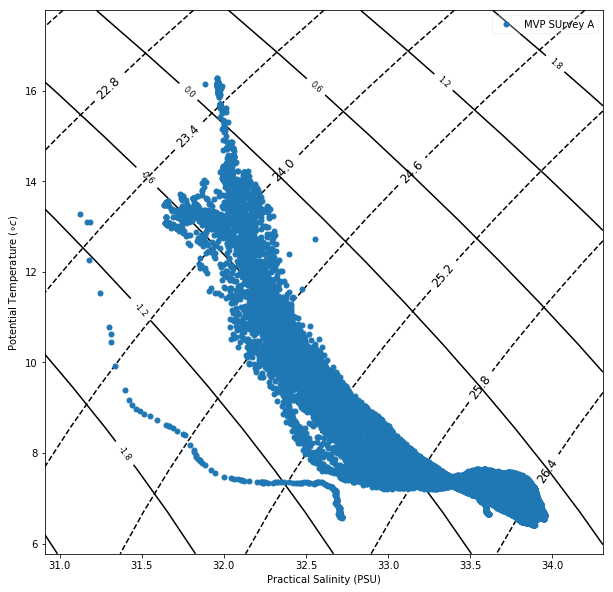

In [18]:
SA_loc_cs = []
CT_loc_cs = []

for i in np.arange(sal_survey.shape[1]):
    SA_loc_cs = np.append(arr=SA_loc_cs, values= sal_survey[:,i][np.isfinite(sal_survey[:,i])])
    CT_loc_cs = np.append(arr=CT_loc_cs, values= temp_survey[:,i][~np.isnan(temp_survey[:,i])])


# Figure out boudaries (mins and maxs)
smin = SA_loc_cs.min() - (0.01 * SA_loc_cs.min())
smax = SA_loc_cs.max() + (0.01 * SA_loc_cs.max())
tmin = CT_loc_cs.min() - (0.1 * CT_loc_cs.max())
tmax = CT_loc_cs.max() + (0.1 * CT_loc_cs.max())
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens_1 = np.empty((ydim,xdim))
spic_1 = np.empty((ydim,xdim))
 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        dens_1[j,i]=gsw.rho(si[i],ti[j],0)
        spic_1[j,i] = gsw.spiciness0(si[i],ti[j])
 
# Substract 1000 to convert to sigma-t
dens_1 = dens_1 - 1000
 
# Plot data ***********************************************
fig1, ax = plt.subplots(1, 1, figsize=(10,10))
CS = plt.contour(si,ti,dens_1, linestyles='dashed', colors='k')
CS1 = plt.contour(si,ti,spic_1, linestyles='solid', colors='k')
plt.clabel(CS, fontsize=12, inline=1, fmt='%0.1f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%0.1f') # Label every second level


ax.plot(SA_loc_cs ,CT_loc_cs,'o',markersize=5, label='MVP SUrvey A')

# ax.plot(SA_loc_f, CT_loc_f, 'o' ,markersize=9, label = 'Eddy west front')
# ax.set_ylim(5,18)
# ax.set_xlim(30,34)
 
ax.set_xlabel('Practical Salinity (PSU)')
ax.set_ylabel('Potential Temperature ($\circ c$)')
legend = ax.legend(loc='best', fancybox=True, framealpha=0.25)


In [29]:
SA_loc_cs.shape

(107,)

In [22]:
sal_survey.shape

(251, 203)